In [40]:
%load_ext Cython
%matplotlib widget

In [41]:
import numpy as np
import pandas as pd

from numpy.random import default_rng
rng = default_rng()

import matplotlib.pyplot as plt
from scipy.signal import  convolve2d

In [42]:
rs =  (1/np.sqrt(2)) ** np.arange(2,16)

In [19]:
granularity = 4

In [20]:
step = np.min(rs)/granularity

In [21]:
step

0.0013810679320049738

In [22]:
N = rng.poisson(-np.log(rs)*100)
xy = rng.uniform(size=(np.sum(N),2))
W = rng.normal(size=np.sum(N), scale=0.1)
rsN = np.repeat(rs,N).reshape(np.sum(N),)

In [23]:
df = pd.DataFrame({'x': xy[:,0],'y': xy[:,1],  'W': W, 'rsN':rsN})

In [24]:
df['i'] = np.floor(df['x'] / step).astype(int)
df['j'] = np.floor(df['y'] / step).astype(int)

In [25]:
df_ag = df.groupby(['i', 'j', 'rsN'], as_index=False)['W'].sum()

In [26]:
toto = np.ceil((1/step)).astype(int)
resf = np.zeros((toto,toto))

In [27]:
for r in rs:
    print(r)
    temp = df_ag.loc[df_ag.rsN==r]
    size = np.ceil(r / step) 
    if (size%2)==1:
        size=size+2
    XY = np.arange(size) * step - (r/2)
    X, Y = np.meshgrid(XY, XY,  indexing='ij')
    kernel = X**2 + Y**2 
            
    kernel = (1- (kernel/(r**2)))**2 * (kernel<=(r/2)**2)
    #kernel = 1 * (kernel<=(r/2)**2)
    
    toto = np.ceil((1/step)).astype(int)
    res = np.zeros((toto,toto))
    res[temp.i, temp.j] = temp.W
    resf = resf + convolve2d(res, kernel, 'same')
    

0.4999999999999999
0.3535533905932737
0.24999999999999992
0.1767766952966368
0.12499999999999993
0.08838834764831839
0.06249999999999996
0.04419417382415918
0.031249999999999972
0.022097086912079587
0.015624999999999983
0.011048543456039792
0.0078124999999999905
0.005524271728019895


In [39]:
plt.imshow(resf)

In [37]:
resf.shape

(725, 725)

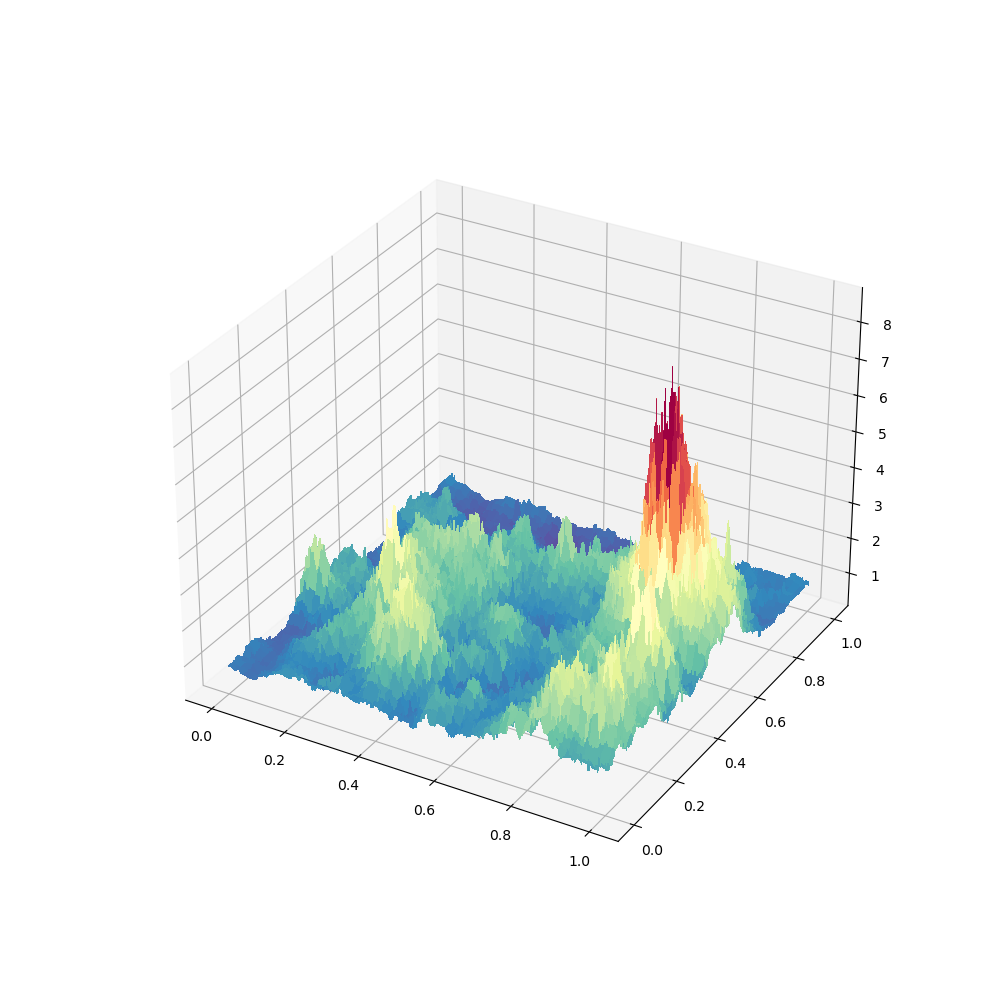

In [30]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
from matplotlib import cm

X, Y = np.meshgrid(np.linspace(0,1,resf.shape[0]), np.linspace(0,1,resf.shape[0]))

surf = ax.plot_surface(X,Y, np.exp(resf), cmap=cm.Spectral_r,
                       linewidth=0, antialiased=False)

In [66]:
resf.shape

(227, 227)

In [59]:
np.min(toto)

0.21907008001241002

In [60]:
np.max(toto)

4.625277642521808

In [54]:
toto = np.ceil((1/step)).astype(int)
res = np.zeros((toto,toto))
res[temp.i, temp.j] = temp.W

In [52]:
res

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [55]:
res2 = convolve2d(res, kernel)

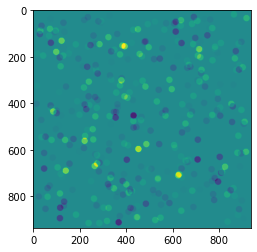

In [57]:
plt.imshow(res2)

In [101]:
XY.shape

(227,)

In [103]:
size

231.0

In [18]:
%%cython

import numpy as np
def convolve2d(f, g):
    # f is an image and is indexed by (v, w)
    # g is a filter kernel and is indexed by (s, t),
    #   it needs odd dimensions
    # h is the output image and is indexed by (x, y),
    #   it is not cropped
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    # smid and tmid are number of pixels between the center pixel
    # and the edge, ie for a 5x5 filter they will be 2.
    #
    # The output size is calculated by adding smid, tmid to each
    # side of the dimensions of the input image.
    vmax = f.shape[0]
    wmax = f.shape[1]
    smax = g.shape[0]
    tmax = g.shape[1]
    smid = smax // 2
    tmid = tmax // 2
    xmax = vmax + 2*smid
    ymax = wmax + 2*tmid
    # Allocate result image.
    h = np.zeros((xmax, ymax), dtype=f.dtype)
    # Do convolution
    for x in range(xmax):
        for y in range(ymax):
            # Calculate pixel value for h at (x,y). Sum one component
            # for each pixel (s, t) of the filter g.
            s_from = max(smid - x, -smid)
            s_to = min((xmax - x) - smid, smid + 1)
            t_from = max(tmid - y, -tmid)
            t_to = min((ymax - y) - tmid, tmid + 1)
            value = 0
            for s in range(s_from, s_to):
                for t in range(t_from, t_to):
                    v = x - smid + s
                    w = y - tmid + t
                    value += g[smid - s, tmid - t] * f[v, w]
            h[x, y] = value
    return h

In [54]:
df
    
XY = np.arange(0,1, np.min(rs)/granularity)
X, Y = np.meshgrid(XY, XY,  indexing='ij')
cpc = np.ones(X.shape)

In [55]:
df

,x,y,W,rsN,i,j
0,0.381930,0.383441,-0.231892,0.707107,172,173
1,0.013565,0.417022,-0.552822,0.707107,6,188
2,0.760745,0.668989,-1.975905,0.707107,344,302
3,0.531306,0.298686,0.529363,0.707107,240,135
4,0.797296,0.702088,-0.661778,0.707107,360,317
...,...,...,...,...,...,...
1520,0.839783,0.363743,0.925389,0.044194,380,164
1521,0.645305,0.928680,-1.000496,0.044194,292,420
1522,0.937446,0.933401,-1.275033,0.044194,424,422
1523,0.591791,0.859028,1.888333,0.044194,267,388


In [19]:
np.floor(XY /step)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  28.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  56.,  57.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 113., 114., 115., 116., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [3]:

def CoumpoundPoissonCascade(rs, granularity=20):
    N = rng.poisson(-np.log(rs)*100)
    xy = rng.uniform(size=(np.sum(N),2))
    W = rng.lognormal(size=(np.sum(N),1),sigma=0.01)
    
    rsN = np.repeat(rs,N).reshape(np.sum(N),1)
    
    XY = np.arange(0,1, np.min(rs)/granularity)
    X, Y = np.meshgrid(XY, XY,  indexing='ij')
    cpc = np.ones(X.shape)
    
    return(inside(rs, N, xy, W, granularity, cpc, rsN,XY,X,Y))

@jit
def inside(rs, N, xy, W, granularity, cpc, rsN,XY,X,Y):  


     
    for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                for k in range(xy.shape[0]):
                    if ((xy[k,0] - X[i,j])**2 + (xy[k,1] - Y[i,j])**2) < (rsN[k] / 2)**2:
                            cpc[i,j] = cpc[i,j] * W[k]
    return(cpc)
   

In [ ]:
cpc1 = CoumpoundPoissonCascade(rs)

/tmp/ipykernel_899/3137620607.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "inside" failed type inference due to: No implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(float64, 2d, C), UniTuple(int64 x 2), array(float64, 1d, C))
 
There are 16 candidate implementations:
  - Of which 16 did not match due to:
  Overload of function 'setitem': File: <numerous>: Line N/A.
    With argument(s): '(array(float64, 2d, C), UniTuple(int64 x 2), array(float64, 1d, C))':
   No match.

During: typing of setitem at /tmp/ipykernel_899/3137620607.py (23)

File "../../../../tmp/ipykernel_899/3137620607.py", line 23:
<source missing, REPL/exec in use?>

  @jit
/tmp/ipykernel_899/3137620607.py:14: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "inside" failed type inference due to: Cannot determine Numba type of <class 'numba.core.di

In [182]:
cpc2 = cpc(rs)

(-0.5, 452.5, 452.5, -0.5)

<Figure size 432x288 with 0 Axes>

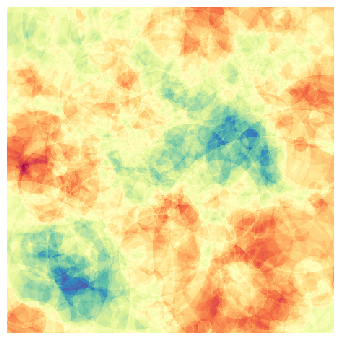

In [163]:
fig = plt.figure(frameon=False)
plt.figure(figsize=(6,6))
Z1 = np.add.outer(range(8), range(8)) % 2  # chessboard
im1 = plt.imshow(np.log(cpc2), cmap=plt.cm.Spectral, interpolation='nearest')
plt.axis('off')

(-0.5, 452.5, 452.5, -0.5)

<Figure size 432x288 with 0 Axes>

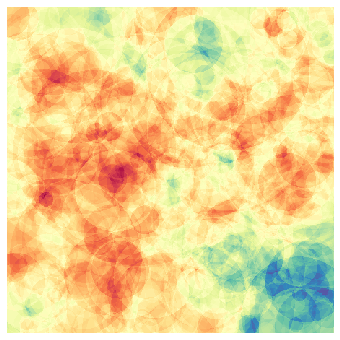

In [37]:
fig = plt.figure(frameon=False)
plt.figure(figsize=(6,6))
Z1 = np.add.outer(range(8), range(8)) % 2  # chessboard
im1 = plt.imshow(np.log(cpc1), cmap=plt.cm.Spectral, interpolation='nearest')
plt.axis('off')

(-0.5, 452.5, 452.5, -0.5)

<Figure size 432x288 with 0 Axes>

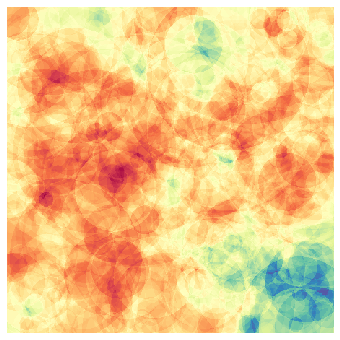

In [38]:
fig = plt.figure(frameon=False)
plt.figure(figsize=(6,6))
Z1 = np.add.outer(range(8), range(8)) % 2  # chessboard
im1 = plt.imshow((cpc1), cmap=plt.cm.Spectral, interpolation='nearest')
plt.axis('off')

In [183]:
ratio = cpc1 / (cpc1 + cpc2)

(-0.5, 452.5, 452.5, -0.5)

<Figure size 432x288 with 0 Axes>

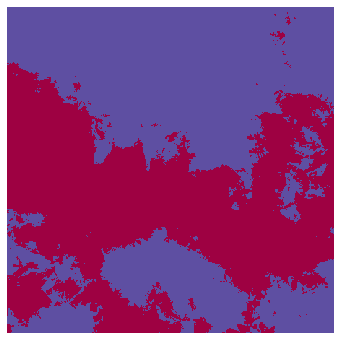

In [185]:
fig = plt.figure(frameon=False)
plt.figure(figsize=(6,6))
Z1 = np.add.outer(range(8), range(8)) % 2  # chessboard
im1 = plt.imshow((ratio>0.5), cmap=plt.cm.Spectral, interpolation='nearest')
plt.axis('off')

In [136]:
N = rng.poisson(-np.log(rs)*100)

In [154]:
xy = rng.uniform(size=(np.sum(N),2))
W = rng.lognormal(size=(np.sum(N),1))
rsN = np.repeat(rs,N).reshape(np.sum(N),1)
cpc_init = pd.DataFrame(np.concatenate([xy,W, rsN], axis=1), columns=['x', 'y', 'W', 'r'])

In [155]:
granularity = 20
XY = np.arange(0,1, np.min(rs)/granularity)
X, Y = np.meshgrid(XY, XY,  indexing='ij')
cpc = np.ones(X.shape)

In [156]:
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        cpc[i,j] = np.prod(cpc_init.W[((cpc_init.x - X[i,j])**2 + (cpc_init.y - Y[i,j])**2) < (cpc_init.r / 2)**2])

(-0.5, 452.5, 452.5, -0.5)

<Figure size 432x288 with 0 Axes>

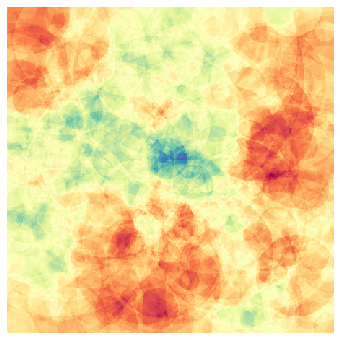

In [157]:
fig = plt.figure(frameon=False)
plt.figure(figsize=(6,6))
Z1 = np.add.outer(range(8), range(8)) % 2  # chessboard
im1 = plt.imshow(np.log(cpc), cmap=plt.cm.Spectral, interpolation='nearest')
plt.axis('off')

(-0.5, 452.5, 452.5, -0.5)

<Figure size 432x288 with 0 Axes>

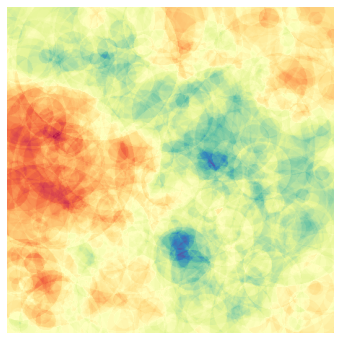

In [153]:
fig = plt.figure(frameon=False)
plt.figure(figsize=(6,6))
Z1 = np.add.outer(range(8), range(8)) % 2  # chessboard
im1 = plt.imshow(np.log(cpc), cmap=plt.cm.Spectral)
plt.axis('off')

NameError: name 'XY' is not defined

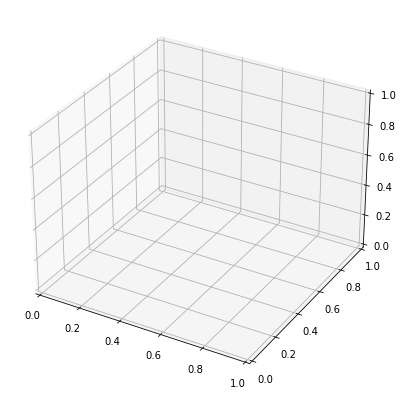

In [15]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(XY, XY.reshape(XY.shape[0],1), (cpc1),  cmap='Spectral', edgecolor='none')

In [117]:
XY.reshape(1,227)

array([[0.        , 0.00441942, 0.00883883, 0.01325825, 0.01767767,
        0.02209709, 0.0265165 , 0.03093592, 0.03535534, 0.03977476,
        0.04419417, 0.04861359, 0.05303301, 0.05745243, 0.06187184,
        0.06629126, 0.07071068, 0.0751301 , 0.07954951, 0.08396893,
        0.08838835, 0.09280777, 0.09722718, 0.1016466 , 0.10606602,
        0.11048543, 0.11490485, 0.11932427, 0.12374369, 0.1281631 ,
        0.13258252, 0.13700194, 0.14142136, 0.14584077, 0.15026019,
        0.15467961, 0.15909903, 0.16351844, 0.16793786, 0.17235728,
        0.1767767 , 0.18119611, 0.18561553, 0.19003495, 0.19445436,
        0.19887378, 0.2032932 , 0.20771262, 0.21213203, 0.21655145,
        0.22097087, 0.22539029, 0.2298097 , 0.23422912, 0.23864854,
        0.24306796, 0.24748737, 0.25190679, 0.25632621, 0.26074563,
        0.26516504, 0.26958446, 0.27400388, 0.2784233 , 0.28284271,
        0.28726213, 0.29168155, 0.29610096, 0.30052038, 0.3049398 ,
        0.30935922, 0.31377863, 0.31819805, 0.32

In [53]:
rs =  (1/np.sqrt(2)) ** np.arange(0,10)
rs

array([1.        , 0.70710678, 0.5       , 0.35355339, 0.25      ,
       0.1767767 , 0.125     , 0.08838835, 0.0625    , 0.04419417])

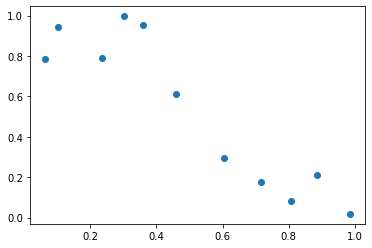

In [55]:
test = poisson_process(-10*np.log(rs[2]))
plt.scatter(test[:,0], test[:,1])

In [59]:
[poisson_process(-10*np.log(r)) for r in rs]

[array([], shape=(0, 2), dtype=float64),
 array([[0.41793349, 0.12564263],
        [0.93271225, 0.49761152],
        [0.00420906, 0.63510888]]),
 array([[0.94974939, 0.43327649],
        [0.03914744, 0.74854451],
        [0.48769916, 0.94082486],
        [0.42481633, 0.82153112],
        [0.42880499, 0.54833885],
        [0.69936181, 0.43233374],
        [0.43966084, 0.34504676],
        [0.31391489, 0.85520753]]),
 array([[0.47516033, 0.84593822],
        [0.37392838, 0.4025268 ],
        [0.05322908, 0.31955689],
        [0.38994277, 0.68539085],
        [0.13909947, 0.71256586],
        [0.28308495, 0.11954599],
        [0.18628651, 0.82388658],
        [0.41716475, 0.74597893],
        [0.63725204, 0.19602139],
        [0.53163145, 0.98233085]]),
 array([[0.78742058, 0.59652217],
        [0.28200335, 0.05547244],
        [0.21318872, 0.5739229 ],
        [0.0199117 , 0.73732773],
        [0.66248795, 0.52612977],
        [0.75416114, 0.99522762],
        [0.24228588, 0.39921933],
 